# Introduction to Recurrent Neural Networks

### Machine Learning 410
### Steve Elston

## 1.0 Introduction to neural networks

In this lesson you will explore **recurrent neural networks (RNNs)**. Recurrent neural networks use a distinctive model which is suitable for sequence data. Sequence data can include human speech, natural language, and numerical time series. Natural language applications include machine translation and question response systems. RNNs can also be applied to multi-dimensional data. For example, RNNs are used to caption images.    

### 1.1 Basic recurrence relationships for neural networks

**Recurrent neural networks (RNNs)** use recurrence operations to operate on **sequences**. But, what do we mean by a recurrence? Simply put, recurrent functions are functions that call themselves to process values of a sequence. 

Let's look at a simple example. Start with a function that operates on a value at one time step to compute an output at the next time step. We can write such a function as follows:

$$s^{(t)} = f(s^{(t-1)}; \theta)$$

This apply this functional relation once again applied again to compute the output at the next time step. This first recurrent relationship can be written as follows.

$$s^{(t+1)} = f(f(s^{(t-1)}; \theta); \theta)$$

We can continue in this way to compute the output of any **finite** sequence of inputs. It is important to understand that this recurrence reltionship in not defined for an infinite length sequence. In paractice, all problems for which we apply the recurrence relationship are finite. 

Notice that the recurrence relationship intorduces **memory**. The memory property of this model differentiates it from many classical time series models. In technical terms we can say the recurrence model is **non-Markovian**, where a **Markov process** is memoryless.   

### 1.2 Basic recurrent neural network architecture

How do we create a neural network with a recurrence relationship? A single hidden layer recurrent neural network is illustrated in Figure 1.1 below. The hidden layer of this network has a recurrent or feedback path. This RNN produces an output value (or vector) for each input.     

<img src="img/Recurrent1.jpg" alt="Drawing" style="width:200px; height:400px"/>
<center>**Figure 1.1. Basic architecture of a recurrent process**</center>

Figure 1.1 illustrates the concept of an RNN. But, how can this architecture be used to perform actual compuations? The answer is to **unfold** the recurrence relationship. This unfolding is illustrated in Figure 1.2. Notice that the unfolded network represents a long sequence of calculations. 

<img src="img/Unfolded1.jpg" alt="Drawing" style="width:450px; height:400px"/>
<center>**Figure 1.2. Unrolled basic recurrent process**</center>

The capital letters in Figure 1.2 represent weight tensors of the model. It is these weight tensors that must be learned when training an RNN. Typcially, these weight tensors are learned by using **back propagation through time (BPTT)**. BPTT is a generalization of the general back propagation algorithm. 

The weight tensor $W$ defines the recurrence. You can see that this connection from one time step to another introduces memory into the model. 

Given these weight tensors the feed-forward calculation for a multinomial classifier RRN can be writen as follows:  

$$a^{(t)} = b + W h^{(t-1)} + Ux^{(t)}\\
h^{(t)} = tanh(a^{(t)})\\
o^{(t)} = c + Vh^{(t)}\\
\hat{y}^{(t)} = softmax(o^{(t)})$$

These relationships are relatively complex. This is especially the case when comparied to basic fully-connected networks. 

In the equations above notice that there is only a dependency on the previous activation, $h^{(t-1)}$, and the current input, $x^{(t)}$. There is no dependency on anything that occurs after the current time step. Therefore, we can stay that this basic recurrent neural network is **causal**. For many problems in sequence analysis causality is an essential property. For example, in a forecasing application there will never be any information available beyone the present. 

Notice that the weight tensors of the RNN are the same at each time step. This fact has two important implications.
1. These **Shared weight** tensors are learned. This makes the training of RNNs tractable. Furhter, the statistical strenght of the training is increased. 
2. The RNN can only be used to model **stationary** sequences. A stationary sequence has statistical properties (e.g. variance) that are **invariant with time**.   

### 1.3 Recurrent network with single output

The RNN architecture illustrated in Figure 1.3 has only one output that is generated only once the end of the sequence is encountered. This type of RNN can be used in a number of ways. For example, the single output RNN can be used as a trigger that detects a certain patern in a sequence. In can also be used as a classifier for the input sequence.   

<img src="img/RNNwithSingOutput.JPG" alt="Drawing" style="width:500px; height:400px"/>
<center>**Figure 1.3. RNN with single output**</center>

A common issue with single output RNNs is difficulty with training. BPTT requires a gradient based on the partial derivatives of the loss function weights with respect to the weights. This gradient can only be computed at the end of each sequence. This situation can greatly slow training if the sequences are long or arrive infrequenty. 

## 2.0 Text example with Keras

Let's see how some of this theory works in practice using Keras. Execute the code in the cell below to load the required packages.

In [1]:
from keras import layers
from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from keras import regularizers
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\StevePC2\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 2.1 Overview of text embedding

In the following examples we will use a feature extraction technique known as **text embedding**. A text embedding layer is often used to extract features before RNN layers are used. This general architecture is shown in Figure 2.1 

<img src="img/Architecture.JPG" alt="Drawing" style="width:250px; height:250px"/>
<center>**Figure 2.1. General architecture for deep learning with text**</center>

We will not dive deeply into NLP for this lesson since our focus is on RNNs. However, a bit of background will help you understand what is going on.

First a bit of terminology. We talk about a **corpus**, which a collection of **documents**. A document can take many forms; a email, a tweet, a news artical, a book, a chapter from a book, a paragraph, etc. 

There are a great many models which have been tried for text analytics and **natural language processing (NLP)**. Typically, NLP with raw text requires significant preparation.  A few of many possible preparation steps include: 
- Text is normalized, which can involve many steps such as setting characters to lower case, removing puntuation, numbers and special characters. In some cases, **stop words** are removed. Stop words are common words with no sematic value, such as 'the' or 'and'. 
- Normalized text is **tokenized**. There are a number of ways to tokenize text. Most coommonly the tokens are the words in the document. Tokens can also be characters or any other division of the document that make symantic sense. 

We will only discuss a few of common models briefly here: 

- The **bag of words model (BOW)** is a simple widely used and suprsingly effective model for analysis of text data. The BOW model assumes **exchangeability** of words. The BOW model depends only on the frequency of the words in the document. The order of the words is not consisdered. Dispite these seamingly rediculous assumptions, the model wo rks well in many cases. The end product of applying the BOW model is a term-document or document-term matrix. The tdm, or dtm is a structured representation of word frequency by document. The tdm or dtm can be used for classification if lables are available or clustering for unspervised learning. In general the tdm or dtm are extremely sparse. Most words in a typical corpus do not show up in most documents. This sparscesity requires that special data structures are used for storage and manipulation. Further, the sparse representation leads to statistical issues. 
- The **N-gram** model uses all possible sequences of N words. For example, the 3-gram of the sentance 'The cat sat on the mat' is as follows:
 - All possible 1-grams; the, cat, sat, on, mat. Note that the 1-gram model is close to the BOW model. 
 - All possible 2-grams; the cat, cat sat, sat on, on the, the mat. 
 - All possible 3-grams; the cat sat, cat sat on, sat on the, on the mat. 
- Another widely used model is **Part of Speech (PoS) Tagging**. PoS tagging attempts to label or anotate words in a corpus (e.g. a collection of documents) as, say nouns, verbs, pronouns, etc. PoS tagging is beyond the  scope of this Lesson. The PoS tagger creates a tree of the relationship of words in say a sentance. One useful specialization of PoS tagging is named entity recognition, which attempts to find proper nouns. 

With the advent of deep learning, text embedding models have come into common use. Embedding models map the tokens (typically words) in the documents to a dense space of learned features. The dense represenation has significant statisticall advantages when training models. Further minimal storage is requred for the dense representation. 

Similar words lie near each other in the embedding space in a maner that preserves symantic relationships. This relationship between some words is shown scematically in Figure 2.2. You can see that simplar words are close to each other. Further, words with similar sematic relationships are along nearly parallel vectors in this space.    

![](img/Embedding.JPG)
<center>**Figure 2.2. Schematic diagram of embedding relationship between common words**</center>

Text embedding has been shown to work extremely well in practice. Unfortunately, like many topics in deep learning, theory has not caught up with practice. Beyond the conceptual level theory is sketchy. The most readable source on the theory of embedding is the [article by Rong](https://arxiv.org/pdf/1411.2738.pdf).

### 2.2 Simple text embedding example

Let's try a simple sentiment classifier using text embedding. We will try sentiment analysis of movie review text using the IMDB dataset built into Keras. This dataset includes the full text of a number of movie reviews, along with labels indicating if the review has positive of negative sentiment. 

***
**Note.** A sentiment analysis example is not ideal to demonstrate appling RNNs to text. Most likely, this fact arrises from the fact that word order of the squence is less important in this applicaiton. 
***

The code in the cell below performs the following steps:
1. Loads the IMDB data into train and test subsets.
2. Pads the squence of words in each review so that all sequences have the same length. In this case, the first 250 words are used. Shorter reviews are padded with zeros. Padding is required so that Keras neural networks can operate on the input. 
3. Prints some summary information on the result.

In [2]:
max_features = 10000
max_len = 250
(train_text, train_labels), (test_text, test_labels) = imdb.load_data(num_words = max_features)
train_text = preprocessing.sequence.pad_sequences(train_text, maxlen = max_len)
test_text = preprocessing.sequence.pad_sequences(test_text, maxlen = max_len)
print(len(train_text))
print(train_text[1])

25000
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    1  194 1153  194 8255   78  228    5    6
 1463 4369 5012  134   26    4  715    8  118 1634   14  394   20   13
  119  954  189  102    5  207  110 3103   21   14   69  188    8   30
   23    7    4  249  126   93    4  114    9 2300 1523    5  647    4
  116    9   35 8163    4  229    9  340 1322    4  118    9    4  130
 4901   19    4 1002    5   89   29  952   46   37    4  455    9   45
   43   38 1543 1905  398    4 1649   26 6853    5  163   11 3215    2
    4 1153    9  194  775    7 8255    2  349 2637  148  605    2 8003
   15  123  125   68    2 6853   15  349  165 4362   98    5    4  228
    9   43    2 1157   15  299  120    5  120  174   11  220  175  136


The corpus contains 25,000 documents, or movie reviews in the training dataset. The encoding of the second review is printed. The first many entries in the list are 0, which is the padding. The integers are used to encode each word. The integer encoding creates a data structure suitable for use with neural networks or other machine learning. The assignment of these codes in arbitrary.  

Now, you will create a basic (not RNN) neural network model to classify the sentiment of these reviews. The code in the cell below does the following:

1. Creates a Keras sequential model following the usual recipe. 
2. The first 10,000 documents are used to create an embedded feature space of dimension 8. 
3. The embedded represenation is flattened. 
4. A fully-connected or dense layer is used as a binary classifier for the sentiment, positive or negative. 

In [3]:
embedding = Sequential()
## First add an embedding layer
embedding.add(Embedding(10000, 8, input_length = max_len))
## Flatten the embedding of the features
embedding.add(Flatten())
## Now the  binary classifier layer
embedding.add(Dense(1, activation = 'sigmoid'))
embedding.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])
embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 8)            80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2001      
Total params: 82,001
Trainable params: 82,001
Non-trainable params: 0
_________________________________________________________________


Notice that the embedding layer has many times more parameters than the fully connected output layer. This situation is typical with these types of architectures. 

Next, execute the code in the cell below to fit or train this model. 

In [4]:
historyEMB = embedding.fit(train_text, train_labels,
                   epochs = 10,
                   batch_size = 256,
                   validation_data = (test_text, test_labels))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 76us/step - loss: 0.6840 - acc: 0.5775 - val_loss: 0.6530 - val_acc: 0.7113
Epoch 2/10
25000/25000 [==============================] - 1s 53us/step - loss: 0.5552 - acc: 0.7907 - val_loss: 0.4746 - val_acc: 0.8224
Epoch 3/10
25000/25000 [==============================] - 1s 55us/step - loss: 0.3846 - acc: 0.8640 - val_loss: 0.3582 - val_acc: 0.8603
Epoch 4/10
25000/25000 [==============================] - 1s 57us/step - loss: 0.2953 - acc: 0.8912 - val_loss: 0.3127 - val_acc: 0.8714
Epoch 5/10
25000/25000 [==============================] - 2s 73us/step - loss: 0.2484 - acc: 0.9104 - val_loss: 0.2897 - val_acc: 0.8785
Epoch 6/10
25000/25000 [==============================] - 2s 72us/step - loss: 0.2174 - acc: 0.9211 - val_loss: 0.2786 - val_acc: 0.8825
Epoch 7/10
25000/25000 [==============================] - 2s 66us/step - loss: 0.1946 - acc: 0.9307 - val_loss: 0.2744 - val_acc

This fairly naive model works suprisingly well. The result is far from state-of-the-art, but not terrible. 

Now, execute the code in the cell below to examine the histor of loss vs. epoch. 

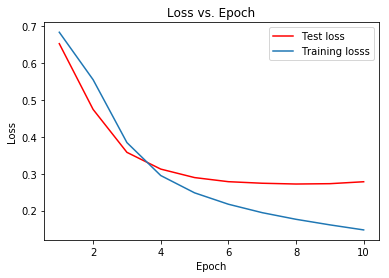

In [5]:
def plot_loss(history):
    '''Function to plot the loss vs. epoch'''
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red', label = 'Test loss')
    plt.plot(x, train_loss, label = 'Training losss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    
plot_loss(historyEMB)    

The loss function appears relatively well behaived. The loss decreases rapidly and then plateaus. 

Run the code below to examine the accuracy vs. epoch.

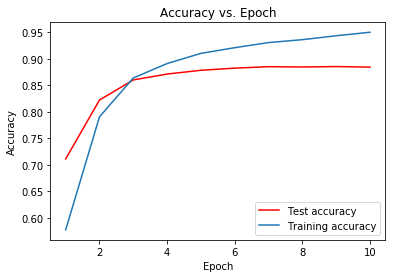

In [6]:
def plot_accuracy(history):
    train_acc = history.history['acc']
    test_acc = history.history['val_acc']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'Test accuracy')
    plt.plot(x, train_acc, label = 'Training accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')  
    
plot_accuracy(historyEMB) 

The behavior of accuracy vs epoch is similarly well behaived like the loss function. 

### 2.3 RNN applied to embedded space

Let's try the same experiment, but using an RNN layer. The code in the cell below is nearly identical to the code used in the first example, except that a `SimpleRNN` layer has been added between the embedding layer and the fully-connected layer. Execute this code and observe the results. 

In [7]:
RNN1 = Sequential()
## First add an embedding layer
RNN1.add(Embedding(max_features, 32))
## Now add an RNN layer
RNN1.add(SimpleRNN(32, kernel_regularizer = regularizers.l2(0.005)))
## And the classifier layer
RNN1.add(Dense(1, activation = 'sigmoid'))
RNN1.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])
RNN1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


This model has significantly greater complexity than the first model. The embedding layer is now producing a sequence of 32 for the RNN layer. This leads to many more weights or parameters. Notice that the output or classifier layer is now quite a bit simpler as it only has 32 inputs and weights. 

Execute the code in the cell below to train this model. 

In [8]:
historyRNN = RNN1.fit(train_text, train_labels,
                   epochs = 10,
                   batch_size = 1024,
                   validation_data = (test_text, test_labels))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 12s 465us/step - loss: 0.8196 - acc: 0.5571 - val_loss: 0.7873 - val_acc: 0.5890
Epoch 2/10
25000/25000 [==============================] - 19s 759us/step - loss: 0.7207 - acc: 0.6996 - val_loss: 0.5970 - val_acc: 0.7806
Epoch 3/10
25000/25000 [==============================] - 14s 546us/step - loss: 0.5723 - acc: 0.7918 - val_loss: 0.5387 - val_acc: 0.7942
Epoch 4/10
25000/25000 [==============================] - 23s 935us/step - loss: 0.4818 - acc: 0.8367 - val_loss: 0.6519 - val_acc: 0.6866
Epoch 5/10
25000/25000 [==============================] - 15s 603us/step - loss: 0.4432 - acc: 0.8467 - val_loss: 0.4948 - val_acc: 0.8097
Epoch 6/10
25000/25000 [==============================] - 11s 429us/step - loss: 0.3916 - acc: 0.8690 - val_loss: 0.4886 - val_acc: 0.8078
Epoch 7/10
25000/25000 [==============================] - 11s 430us/step - loss: 0.3527 - acc: 0.8858 - val_loss: 0.

The loss and accuracy achieved with the RNN layer is similar to, but not quite as good as the first model. For the application the recurrence is evidently not helpful. 

Execute the code in the cell below and examine the loss vs. epoch for this model. 

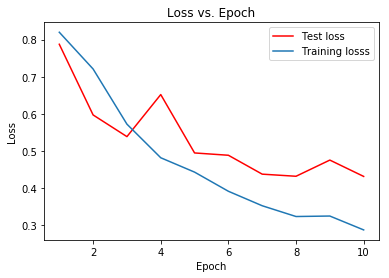

In [9]:
plot_loss(historyRNN)    

The loss function looks rather erratic across the epochs. This may (or may not) be a sign that the training of this model with so many parameters is struggling. 

Execute the code in the cell below ad examine the result. 

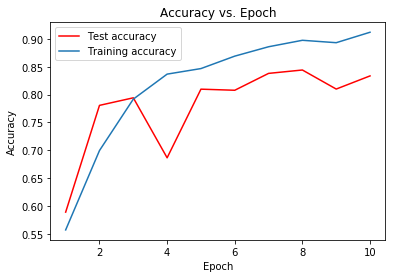

In [10]:
plot_accuracy(historyRNN) 

As with loss, accuracy shows quite erratic behavior with epoch. The training of  this model may be struggling which helps explain the lackluster perforance. 

***
**Note** For production work with embedding layers, pretrained models are generally used as a starting point. These models have been trained on a wide range of corpora. Therefore, these models are likely to be more powerful and less susceptible to unexpected behavior when faced with new input sequences. 
***

## 3.0 Sequence generation with RNNs

There are many interesting applications which generates a sequnce given a, possibly vector, input. A few of the applications of such a system include:
- A speach generation for a question-response system, where the output sequence is a response to a question type.
- Generating the words of image captions given the class of the image.  

A schematic architecture for a sequence generation RNN is shown in Figure 3.1 below. This is a simple example of a **generative model**. That is, it generates a squence in response to the input. We can understand the operation of this network as follows:
1. The network has a single input, $x$. 
2. The activations at a step $t$ in the sequence $h^{(t)}$ are determined by the value of $x$ and the expected value of the output $y^{(t)}$.
3. The loss function at each time step $t$, $L^{(t)}$, has two arguments $y^{(t-1)}$ and $\hat{y}^{(t)}$. 

<img src="img/SequenceGenRNN.jpg" alt="Drawing" style="width:475px; height:400px"/>
<center>**Figure 3.1. Sequence generation with RNN**</center>

## 4.0 Adding depth to RNNs

The RNN architectures we have discussed so far in this lesson have been shallow with only a single recurrent hidden layer. Having a single hidden layer limits the representation capacity of the RNN. It is an attractive concept to add additional layers 

To overcome the limitations of a single hidden recurrent layers, deep architectures can be used in principle. There are serveral possibilites for adding depth to the basic RNN architecture. While these ideas are not new, none is completely satisfactory, and research on alternatives continue.

One possibible archietecture is shown in Figure 4.1. This architecture takes a simple approach of stacking recurrent layers. This architecture can be effective in some cases, but suffers from being difficult to train, particularly with both depth and many time steps. 

<img src="img/DeepRNN1.jpg" alt="Drawing" style="width:200px; height:400px"/>
<center>**Figure 4.1. Basic deep RNN**</center>

Another possibility is to add another neural network in the recurrence loop is shown in Figure 4.2. The chosen depth and breath of this additional network can add significant capacity to the model. 

The delay caused by the additional neural network affects the behavior of the recurrence relationship. A solution to this problem is to add the **skip loop** shown in Figure 4.2. The skip loop makes the recurrence responsive to each time step. The skip loop is essentially just another memory, with another assoicated set of weights. 

<img src="img/DeepRNNSkip.jpg" alt="Drawing" style="width:250px; height:400px"/>
<center>**Figure 4.2. RNN with skip connection**</center>



As with other deep RNN architectures the ones shown in Figures 4.1 and 4.2 are not ideal.  Training can prove to be slow and difficult as we will discuss in the next section. 

## 5.0 RNNs with memory

In this section we will explore **long-short term (LSTM)** neural networks and a related architecture known as **gated recurrent units (GRU)**. These architectures are the backbone of many real-world deep learning applications. LSTM and GRU networks are used for machine translation, NLP,and speach recognition to name just a few. In fact, virtually all large-scale production applications of RNNs use some kind of memory architecture. 

LSTM and GRU networks have proven farily easy to train.  This is in contrast to simple recurrent neural networks, which can prove difficult to train. The difficulty training is generally the result of the **vanishing gradient** and **exploding gradient** problems discussed in the optimizatiton lesson. To gain some insight into why this might be, consider the recurrence relationship with a single input, $s^{(t)}$, after $n$ time steps:

$$s^{(t+n)} = f(f(....f(f(s^{(t)}; \theta));\theta)$$

Now if maginitude of $f(s; \Theta)$ is greater than $1.0$ the output value will increase exponentially, leading to an exploding gradinet after a long sequence. Conversly, if the maginitude of $f(s; \Theta)$ is less than $1.0$ the output value will decrease with an exponential decay, and the gradient will vanish after a long sequence. 

What can be done to correct the aforementioned situation? One effective solution is to add memory to the RNN. The memory makes the RNN sensitive to multiple time scales. Along with the memory as series of **forget gates** are added. Forget gates allow the the network to operate with multiple time scales. Limiting memory time limits the number of time periods for recurrence which limits vanishing and exploding gradients.  

A readable summary and comparison of LSTM and GRU architectures can be found in the [paper by Chung et. al.](https://arxiv.org/abs/1412.3555). Chung et. al. compare the performance of both architectures for serveral tasks and datasets and find that which works better is dataset and task dependent.

### 5.1 LSTM networks

An example of a neural network with memory and forget gates, known as an LSTM, is illustrated in Figure 5.1 below. This architecture was originally proposed by Hochreiter and Schmidhuber in 1997. This architecture uses a series of gates (multiplers with inputs of approximately $0$ or $1$). The memory is shown as the shaded block of the self loop. The other memory loop is shown in green. The purpose of the second memory loop is to control the activations of the forget gates. 

![](img/LSTM1.jpg)
<center>**Figure 5.1. Architecture of long-short term network**</center>

There are quite a few forget gates in the architecture shown in Figure 5.1. The activation or output from the network can be written:

$$\hat{y}^{(t)}_i = \sigma^{(t)}_i \cdot tanh(y^{(t)}_i)$$

Notice that the nonlinearity for the activation is given by the $tanh$ function. The gating function is determined by a sigmoid function:

$$\sigma^{(t)}_i =  \sigma \big(V_{(o)} s^{(t)}_i + U_{(o)} x_i^{(t)} + W_{(o)} h^{(t-1)}_i \big)$$

The **state** of the memory loop is a linear combination of the input and the memory. This relationship can be expressed as:

$$s^{(t)}_i = f^{(t)}_i \cdot s^{(t)}_i + i^{(t)}_i \cdot s^{(t-1)}_i$$

Where the new memory state is expressed as:

$$s^{(t)}_i = tanh(U_{c} x_i^{(t)} + W_{c} h^{(t-1)}_i)$$

The activations of the forget gate and input gate are expressed the the sigmoidal functions:

$$f^{(t)}_i = \sigma \big(V_{(f)} x^{(t)} + U_{(f)} x_i^{(t)} + W_{(f)} h^{(t-1)}_i \big)\\
i^{(t)}_i = \sigma \big(V_{(i)} x^{(t)} + U_{i} x_(i)^{(t)} + W_{(i)} h^{(t-1)}_i \big)$$



### 5.2 GRU networks

The numerious forget gates in the LSTM network leads to some complexity in understanding and in training. The GRU architecture by Cho et. al. in 2014 as a possible simplification of a RNN with multiple time scales. The GRU architecture does not require an explicit memory unit. Instead, GRUs use a weighted decay function for the output activation:

$$h_i^{(t)} = \big( 1 - z _i^{(t)} \big) h_i^{(t-1)} + z _i^{(t)} \tilde{h}_i^{(t-1)}$$

![](img/GRU.JPG)

The update gate is controled by the a sigmoidal function of the following form: 

$$z _i^{(t)} = \sigma \big( U_{(z)} h_i^{(t-1)} + W_{(z)} x^{(t)}_i \big)$$

The **candidate activation**, $\tilde{h}_i^{(t-1)}$, is computed in a similar manerr to the typical recurrent unit using the following relationship: 

$$\tilde{h}_i^{(t-1)} = tanh \big( U( r_i^{(t)} \odot h^{(t-1)}_i) + W_{(z)} x^{(t)}_i \big)$$

The activation of the reset gate are determined by the following relationship:

$$r_i^{(t)} = \sigma \big( U_{(r)} h_i^{(t-1)} + W_{(r)} x^{(t)}_i \big)$$

You can see from the above equations that the architecture GRU is indeed a simplification when compared to the LSTM architecture.

### 5.3 A GRU example

With the above theory in mind, it is time to put these ideas to practice on an example. The code in the cell below is similar to the foregoing examples, but uses a GRU layer. Notice mild l2 regularization has been specified. Execute this code.

In [11]:
GRU1 = Sequential()
## First add an embedding layer
GRU1.add(Embedding(max_features, 32))
## Now add an RNN layer
GRU1.add(GRU(32, kernel_regularizer = regularizers.l2(0.005)))
## And the classifier layer
GRU1.add(Dense(1, activation = 'sigmoid'))
GRU1.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])
GRU1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


The GRU layer has about three times the number of parameters as the simple RNN layer. This should be expected, given the more complex algorithm. Still, because of parameter sharing, this number is not excessive. 

Now, execute the code in the cell below and examine the results. 

In [12]:
historyGRU1 = GRU1.fit(train_text, train_labels,
                   epochs = 10,
                   batch_size = 1024,
                   validation_data = (test_text, test_labels))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 24s 978us/step - loss: 0.8698 - acc: 0.6042 - val_loss: 0.8166 - val_acc: 0.6724
Epoch 2/10
25000/25000 [==============================] - 26s 1ms/step - loss: 0.7302 - acc: 0.7470 - val_loss: 0.5678 - val_acc: 0.8072
Epoch 3/10
25000/25000 [==============================] - 26s 1ms/step - loss: 0.5379 - acc: 0.8139 - val_loss: 0.4744 - val_acc: 0.8405
Epoch 4/10
25000/25000 [==============================] - 26s 1ms/step - loss: 0.4257 - acc: 0.8560 - val_loss: 0.4266 - val_acc: 0.8505
Epoch 5/10
25000/25000 [==============================] - 28s 1ms/step - loss: 0.3720 - acc: 0.8758 - val_loss: 0.4104 - val_acc: 0.8487
Epoch 6/10
25000/25000 [==============================] - 28s 1ms/step - loss: 0.3315 - acc: 0.8904 - val_loss: 0.3708 - val_acc: 0.8634
Epoch 7/10
25000/25000 [==============================] - 28s 1ms/step - loss: 0.3086 - acc: 0.8954 - val_loss: 0.3594 - val_a

The results with the GRU are slightly better than for the simple RNN. 

Next, execute the code in the cell below to display the plot of loss vs. epoch. 

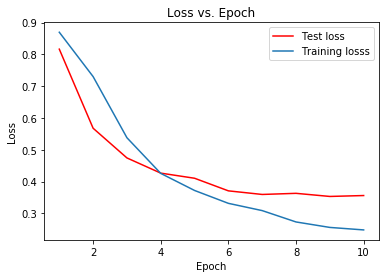

In [13]:
plot_loss(historyGRU1)   

Execute the code in the cell below to display the plot of accuracy vs. epoch. 

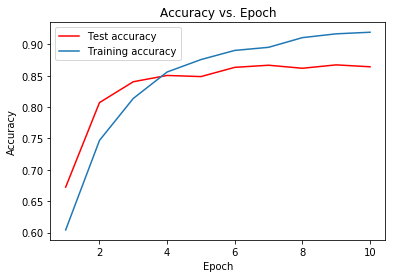

In [14]:
plot_accuracy(historyGRU1) 

Both the test loss and test accuracy show a relatively smooth well-hehaived curve. This is in contrast to the jagged curves obtained for the un-regualized simple RNN tried previously. 

It is possible that bit more regularization and more training epochs would give better results.

## 6.0 Regualarization of RNN

Like all neural networks regularization is typically applied to RNNs. Both l1 and l2 regularization are commonly used. In fact, the foregoing examples use some mild l2 regularization. 

However, dropout has proven difficult to deal with. The usual dropout algorithm causes problems with BPTT. This problem arrises because the Bernoulli sampling at each time step causes instability durring BPTT. 

A solution to this problem has only recently been found by Gal and Ghahramani (2016) and Gal (2016). In these highly technical papers the concept of using dropout as a sampling method for a Gaussian Bayesian model is developed. The solution is to use a special case of dropout in which the Bernoulli sampling is not updated at each forward pass through the network. This method is called **recurrent dropout**. 

The code in the cell below implements the same model as was tested above, but with the addition of dropout. In fact, two types of dropout are used, regular dropout with parameter 0.01 and recurrent dropout with parameter 0.1. it is common practice to include a small amount of conventional dropout along with the reecurrent dropout. Execute this code. 

****
**Note:** This implementationeof the recurrent dropout algorithm in Keras was done by Gal as part of his thesis reserach. 
****

In [15]:
RNN2 = Sequential()
## First add an embedding layer
RNN2.add(Embedding(max_features, 32))
## Now add an RNN layer with dropout
RNN2.add(GRU(32, dropout=0.01, recurrent_dropout=0.1,
            kernel_regularizer = regularizers.l2(0.005)))
## And the classifier layer
RNN2.add(Dense(1, activation = 'sigmoid'))
RNN2.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])
RNN2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


It should come as no suprise that there are same number of parameters for GUR layers with dropout are the same as the layers without dropout. 

Now, execute the code in the cell below to fit the model and examine the result.

In [1]:
historyRNN2 = RNN2.fit(train_text, train_labels,
                   epochs = 15,
                   batch_size = 1024,
                   validation_data = (test_text, test_labels))

NameError: name 'RNN2' is not defined

The error..........................

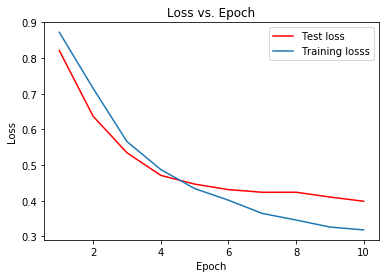

In [17]:
plot_loss(historyRNN2)   

Execute the coded in the cell below 

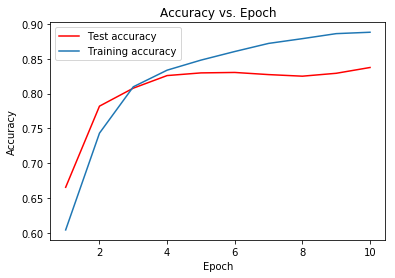

In [18]:
plot_accuracy(historyRNN2) 

## 7.0 Bidirectional RNNs

Up until now we have worked only with RNNs which take steps along a sequence in one direction. As a result, we said these models are causal. However, there are many situations where causality is not important. A few examples include:  
- NLP applications, where the order words are processed is not important. 
- Handwritting recognition, where characters can be recognized in any order. 
- Speach recognition, where the phenomes of a captured utternance are analyized as a group. 
- Figure captioning, where the figure can be understood scanning left to right, right to left, top to bottom and bottom to top. In fact, a 4-directional neural network architecture can be applied to this case. 

Given that order of processing for many sequences does not mater it is possible to go in both directions at once. RNNs that perform such processing are know as **bidirectional RNNs**. An example of a simple bidirectional RNN achitecture is shown in figure 7.1 below. 

![](img/Bidirectional1.JPG)
<center>**Figure 7.1. Architecture of simple bidirectional RNN**</center>

It is relatively straight forward to derrive the propagtion equations for  the case of a simple bidirectional RNN. These equations are  shown below. 

$$a^{(t)} = b + W h^{(t-1)} + Ux^{(t)}\\
i^{(t)} = d + Q g^{(t+1)} + Rx^{(t)}\\
h^{(t)} = tanh(a^{(t)})\\
g^{(t)} = tanh(i^{(t)})\\
o^{(t)} = c + Vh^{(t)} + Sg^{(t)}\\
\hat{y}^{(t)} = softmax(o^{(t)})$$

In addition to the usual weight tensors, $W$ and $U$ ,for the forward case, there are corresponding tensors, $Q$ and $R$ for the backward case. The activation of the forward case is given by $h^{(t)}$, and for the backward case, $g^{(t)}$. The output of the network, $\hat{y}^{(t)}$, is the softmax of the linear combination of these forward and backward activations with weight tensors $V$ and $S$. There bias tensors are required, $c$, $b$, and $d$.

By examining the above equations, one can see that bidirectional RNNs are **non-causal**. As already stated, this property may actually be an advantage in many applications. 

The code in the cell below implements a bidirectional GRU neural network. In Keras, the `bidirectional` operator can wrap most any RNN layer type. This wraper creates the bidirectional version of the specified RNN. In this case we will use a bidirectional GRU. Execute the code. 

In [19]:
bidirection = Sequential()
## First add an embedding layer
bidirection.add(Embedding(max_features, 32))
## Now add an RNN layer
bidirection.add(Bidirectional(GRU(32, kernel_regularizer = regularizers.l2(0.005))))
## And the classifier layer
bidirection.add(Dense(1, activation = 'sigmoid'))
bidirection.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['acc'])
bidirection.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12480     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 332,545
Trainable params: 332,545
Non-trainable params: 0
_________________________________________________________________


Notice that the number of parameters for the RNN layer has doubled from the unidirectional GRU example explored earlier. 

Next, execute the code in the cell below to fit this model and examine the results. 

In [20]:
historyBi = bidirection.fit(train_text, train_labels,
                   epochs = 15,
                   batch_size = 1024,
                   validation_data = (test_text, test_labels))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 79s 3ms/step - loss: 0.8680 - acc: 0.5798 - val_loss: 0.8167 - val_acc: 0.6735
Epoch 2/10
25000/25000 [==============================] - 83s 3ms/step - loss: 0.7363 - acc: 0.7457 - val_loss: 0.6606 - val_acc: 0.7510
Epoch 3/10
25000/25000 [==============================] - 87s 3ms/step - loss: 0.5727 - acc: 0.8044 - val_loss: 0.5356 - val_acc: 0.8128
Epoch 4/10
25000/25000 [==============================] - 93s 4ms/step - loss: 0.4783 - acc: 0.8384 - val_loss: 0.5786 - val_acc: 0.7436
Epoch 5/10
25000/25000 [==============================] - 88s 4ms/step - loss: 0.4104 - acc: 0.8636 - val_loss: 0.4119 - val_acc: 0.8554
Epoch 6/10
25000/25000 [==============================] - 92s 4ms/step - loss: 0.3531 - acc: 0.8813 - val_loss: 0.4510 - val_acc: 0.8122
Epoch 7/10
25000/25000 [==============================] - 92s 4ms/step - loss: 0.3234 - acc: 0.8923 - val_loss: 0.3723 - val_acc

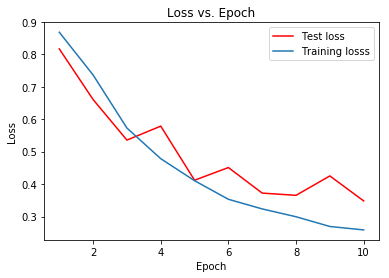

In [21]:
plot_loss(historyBi)   

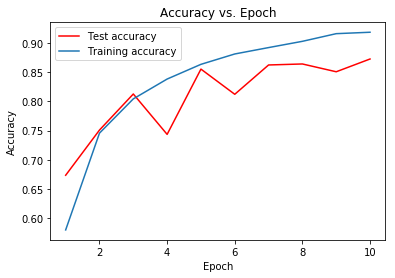

In [22]:
plot_accuracy(historyBi)

## 8.0 RNNs vs. convolutional neural networks

It may have caught your notice that convolutional neural networks could be applied to many of the applications discussed in this lesson. This is in fact the case. For example, a one-dimensional seequence can be modeled by either an RNN or a one-dimensional covnet. 

In some cases covnets have proved superior. This superior performance likely results from the simpler and easier to train model. However, if the underlying process operates over long time scales, then an RNN with memory will likely be superior, since covnets have no memory. 

Emperical evidence indicates that one can only decide which architecture is better for a given application by either deep understanding  of the underlying process, actual testing or both. Testing the various purmutations of these two basic architectures can be quite time consumming. However there  

## 9.0 Multi-task architectures

So far, we have only considered RNN architectures which perform a **single task**. In our examples this task is to estimate sentiment in movie reviews. However, many, if not most, real-world AI applications require more than one task. We say that systems that perform multiple tasks are **multi-task architectures**. Conventionally, these tasks were all performed by independent systems. An advantage of deep architectures is that the multiple tasks can be performed in one stack. Further, the machine learning engineer does not need to explicitly engineer features for these tasks. 

Let's look at a examples of multi-task architecture. Real time translation of human speach to another language. At the minimum there are  four tasks:
- Compute the words in the utterance from the spoken phenomes. 
- Apply NLP to determine the context of the utterance. 
- Create the sequuence of words in the other language. 
- And finally, create the sequence phenomes to form the utterance understandable to the speaker of the other language. 

In this particular application two of the tasks are predictive. But the two other tasks are **generative**. That is, the purpose of these tasks is to compute an output sequence given an input. 

Figure 9.0 shows a schematic architecture for multi-task deep learning. In this  case, the end-to-end task is to transforming utterances in one  language to utterences in another language. 

<img src="img/MultTaskLearning.jpg" alt="Drawing" style="width:475px; height:400px"/>
<center>**Figure 9.0. Deep learning multi-task architecture for machine translation**</center>

#### Copyright 2018, Stephen F Elston. All rights reserved. 